**Emmanuel Decena - ME EE** - Deep Learning Assignment 2

**Unsupervised MNIST Clustering**

## Can we use an autoencoder to build a self-supervised classifier?

### Libraries and Dataset

In [42]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

In [43]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
# reshape to (28, 28, 1), adding 1 to last dimension
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

# normalize input images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Building the Autoencoder

The autoencoder is composed of two parts:
- encoder: A stack of Conv2D(32)-Conv2D(64) with an input layer that takes in the (28,28) MNIST image. The kernel is 3 and batch size is 32. The latent dimension is 4 which is the output of the encoder.
- decoder: A stack of Conv2DTranspose(64)-Conv2DTranspose(32) that takes the latent dimension of 4 as its input. The output is the original image size of (28,28)

#### Encoder

In [53]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 4
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [54]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [55]:
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')

In [56]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 4)                 12548     
Total params: 31,364
Trainable params: 31,364
Non-trainable params: 0
_________________________________________________________________


#### Decoder

In [57]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              15680     
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 71,361
Trainable params: 71,361
Non-trainable params: 0
_______________________________________________________

#### Autoencoder instance

In [58]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')

In [59]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 4)                 31364     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         71361     
Total params: 102,725
Trainable params: 102,725
Non-trainable params: 0
_________________________________________________________________


#### Autoencoder Training

In [60]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')
# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=5,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 210s 4ms/sample - loss: 0.0582 - val_loss: 0.0391
Epoch 2/5
60000/60000 [==============================] - 230s 4ms/sample - loss: 0.0369 - val_loss: 0.0347
Epoch 3/5
60000/60000 [==============================] - 229s 4ms/sample - loss: 0.0344 - val_loss: 0.0334
Epoch 4/5
60000/60000 [==============================] - 317s 5ms/sample - loss: 0.0332 - val_loss: 0.0326
Epoch 5/5
60000/60000 [==============================] - 226s 4ms/sample - loss: 0.0325 - val_loss: 0.0318


## After building the AE, use the trained E to generate feature vectors.

In [61]:
latent_vectors = encoder.predict(x_test)

### Plotting the first two dimensions

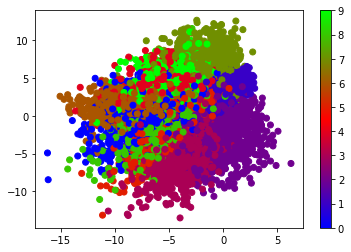

In [62]:

plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=y_test, cmap='brg')
plt.colorbar()
plt.show()


## Use K-means to cluster the feature vectors

In [63]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from munkres import Munkres

In [64]:
# data and true labels
data, classes = latent_vectors, y_test

#Clustering
algo = KMeans(n_clusters=10, random_state = 0)

# performs the algo and get the predicted labels
labels = algo.fit(data).labels_ 

## Use Hungarian Algorithm to assign label to each cluster

In [65]:
def make_cost_matrix(c1, c2):
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

In [66]:
def translate_clustering(clt, mapper):
    return np.array([ mapper[i] for i in clt ])

In [67]:
def accuracy(cm):
    """computes accuracy from confusion matrix"""
    return np.trace(cm, dtype=float) / np.sum(cm)

In [68]:

num_labels = len(np.unique(classes))

cm = confusion_matrix(classes, labels, labels=range(num_labels)) # gets the confusion matrix

In [69]:
print("---------------------\nold confusion matrix:\n" \
          " %s\naccuracy: %.2f" % (str(cm), accuracy(cm)))

---------------------
old confusion matrix:
 [[612   0  13   0   0   8 165   1 181   0]
 [  0   1   0   0 384  11   0   0   0 739]
 [  1 723  17   2  46  85   2   3 136  17]
 [  0  36 640   9   3 190   2   6 115   9]
 [  1   0   0 517  25  18  30 367  18   6]
 [  3   1 263  21  26 193  28  19 338   0]
 [ 25   0   1  12   2  73 741   2 102   0]
 [  0   1   0 195 121   3   1 647   7  53]
 [  1  12 120  12  60 667  10  10  72  10]
 [  1   0   5 490  18  17  13 435  12  18]]
accuracy: 0.23


In [70]:
cost_matrix = make_cost_matrix(labels, classes)

In [71]:
m = Munkres()

In [72]:
indexes = m.compute(cost_matrix)
mapper = { old: new for (old, new) in indexes }

In [73]:
print ("---------------------\nmapping:")
for old, new in mapper.items():
        print ("map: %s --> %s" %(old, new))

---------------------
mapping:
map: 0 --> 0
map: 1 --> 2
map: 2 --> 3
map: 3 --> 4
map: 4 --> 9
map: 5 --> 8
map: 6 --> 6
map: 7 --> 7
map: 8 --> 5
map: 9 --> 1


In [74]:
new_labels = translate_clustering(labels, mapper)
new_cm = confusion_matrix(classes, new_labels, labels=range(num_labels))

In [75]:
print ("---------------------\nnew confusion matrix:\n" \
          " %s\naccuracy: %.2f" % (str(new_cm), accuracy(new_cm)))

---------------------
new confusion matrix:
 [[612   0   0  13   0 181 165   1   8   0]
 [  0 739   1   0   0   0   0   0  11 384]
 [  1  17 723  17   2 136   2   3  85  46]
 [  0   9  36 640   9 115   2   6 190   3]
 [  1   6   0   0 517  18  30 367  18  25]
 [  3   0   1 263  21 338  28  19 193  26]
 [ 25   0   0   1  12 102 741   2  73   2]
 [  0  53   1   0 195   7   1 647   3 121]
 [  1  10  12 120  12  72  10  10 667  60]
 [  1  18   0   5 490  12  13 435  17  18]]
accuracy: 0.56


### Conclusion

Initially the encoder output's accuracy is about 23%. The accuracy increased to 56% after applying the Hungarian algorithm to correct the cluster labels.